In [1]:
# Imports

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from PIL import Image
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import (
    classification_report
    , confusion_matrix
    , ConfusionMatrixDisplay
)

from timeit import default_timer as timer
from tqdm import tqdm
import os
import random
import warnings
warnings.filterwarnings("ignore")

print("torch:", torch.__version__)

torch: 2.2.2


In [2]:
# Device selection (CUDA -> MPS -> CPU)
if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon
else:
    device = "cpu"   # CPU fallback

print("device:", device)

device: mps


In [ ]:
# pip install kagglehub

In [3]:
# os.cpu_count()
int(os.cpu_count() *0.25)
# max(0, min(2, (os.cpu_count() or 2) // 2))

4

In [4]:
# Load the data from the drive:

train_dir = "./data/cars_image_dataset/train/"
test_dir = "./data/cars_image_dataset/test/"

train_dir, test_dir

('./data/cars_image_dataset/train/', './data/cars_image_dataset/test/')

In [5]:
# For init pretrained backbone - EfficientNet_B2 (*For small "toy" sets, EfficientNet_B2 and ConvNeXt-Tiny are both strong.) If acc/loss is not great, swap to ConvNeXt-Tiny by uncommenting the alt block below.

# --- Default: EfficientNet_B2 ---
weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model = models.efficientnet_b2(weights=weights)
preprocess = weights.transforms()

In [6]:
weights, preprocess

(EfficientNet_B2_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [ ]:
# --- ALT: ConvNeXt-Tiny (optional swap) ---
# from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
# weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
# model = convnext_tiny(weights=weights)
# preprocess = weights.transforms()

In [7]:
# Use the preprocess transform for EfficientNet_B2 (preprocess)

num_workers=int(os.cpu_count() *0.25) 

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

len(train_dataset), len(test_dataset)

(3352, 813)

In [8]:
# Derive class names dynamically (no hardcoding)
class_names = train_dataset.classes
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Detected classes:", class_names)

Number of classes: 7
Detected classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


In [9]:
preprocess

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [31]:
### Take a peek at some of the data to get a feel for the shapes, batches, etc.

In [10]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [11]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 1


In [29]:
# get a single img (random - by index int)

images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 19
single image shape: torch.Size([3, 288, 288])
single label: 6


In [32]:
# Start building the model & hyperparams;

In [12]:
# UPDATED EffNetB2 --> w/ 2 add'l layers unfrozen;
# (Next option if not significant increase in metrix --> adjust preprocess: img size to 300 & batches of 16;)

model = model

for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Unfreeze last 2 blocks
n_unfreeze = 2
total_blocks = len(model.features)
for i in range(total_blocks - n_unfreeze, total_blocks):
    for p in model.features[i].parameters():
        p.requires_grad = True

model = model.to(device)

# Optimizer with two groups
backbone_params = [p for m in model.features[total_blocks - n_unfreeze:] for p in m.parameters() if p.requires_grad]
head_params = list(model.classifier.parameters())

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 1e-4}
    , {"params": head_params,     "lr": 5e-4, "weight_decay": 5e-5},
])

# Keep your StepLR or switch to cosine
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [13]:
# Update: functionized train loop;

def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=6, device=device):
    """
    Train a PyTorch model and track training metrics.

    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimization algorithm
        scheduler: Learning rate scheduler
        epochs: Number of training epochs (default 6 epochs for quick initial run; titrate on retrain.)
        device: Device will have been set earlier in process w/ Mac-friendly device-agnostic code;

    Returns:
        tuple: (train_losses, train_accuracies) - lists of training metrics
    """
    # Lists to store metrics over epochs
    train_losses = []
    train_accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        # Compute metrics for this epoch
        train_loss = running_loss / total
        train_acc = correct / total * 100

        # lr scheduler
        scheduler.step()

        # Save metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Print epoch metrics and current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}% | LR: {current_lr:.6f}")

    return train_losses, train_accuracies

In [14]:
%%time
### FIRST TRAINING RUN ###

# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=6
    , device=device
)

# You can now use train_losses and train_accuracies for plotting

 17%|███████▏                                   | 1/6 [01:38<08:12, 98.43s/it]

Epoch 1/6 | Loss: 1.2191 | Acc: 59.5764% | LR: 0.000100


 33%|██████████████▎                            | 2/6 [02:42<05:11, 77.97s/it]

Epoch 2/6 | Loss: 0.4852 | Acc: 87.2912% | LR: 0.000100


 50%|█████████████████████▌                     | 3/6 [03:45<03:34, 71.44s/it]

Epoch 3/6 | Loss: 0.2633 | Acc: 93.2578% | LR: 0.000100


 67%|████████████████████████████▋              | 4/6 [04:50<02:17, 68.74s/it]

Epoch 4/6 | Loss: 0.1553 | Acc: 96.3305% | LR: 0.000100


 83%|███████████████████████████████████▊       | 5/6 [05:53<01:06, 66.90s/it]

Epoch 5/6 | Loss: 0.1098 | Acc: 97.6134% | LR: 0.000080


100%|███████████████████████████████████████████| 6/6 [06:57<00:00, 69.61s/it]

Epoch 6/6 | Loss: 0.0922 | Acc: 97.5537% | LR: 0.000080
CPU times: user 2min 20s, sys: 1min 5s, total: 3min 26s
Wall time: 6min 57s


In [15]:
import pandas as pd

# Build DataFrame from history (will code this in earlier in a later update;)
df_metrics = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics.tail(3)

Epoch  Train Loss  Train Accuracy
3      4    0.155288       96.330549
4      5    0.109807       97.613365
5      6    0.092151       97.553699

In [16]:
df_metrics['Train Loss'].min(), df_metrics['Train Accuracy'].max()

(0.09215129419343283, 97.61336515513126)

In [17]:
current_date = datetime.now().strftime("%Y-%m-%d")
current_date

'2025-11-02'

In [18]:
# Base figure using px for Loss

fig = px.line(
    df_metrics
    , x="Epoch"
    , y="Train Loss", height=600, width=800
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2) ~ {current_date}"
    , markers=True
)

# Add Accuracy trace (assign to y2 axis)
fig.add_scatter(
    x=df_metrics["Epoch"]
    , y=df_metrics["Train Accuracy"]
    , mode="lines+markers"
    , name="Train Accuracy"
    , yaxis="y2"
    , line=dict(width=3)
)

# Configure dual axes
fig.update_layout(
    template="seaborn"
    , title_x=0.5
    , title_font_size=18
    , font=dict(size=14)
    , legend=dict(
        title=None
        , orientation="h"
        , yanchor="bottom"
        , y=1.02
        , xanchor="center"
        , x=0.5
    )
    , xaxis=dict(title="Epoch")
    , yaxis=dict(
        title="Loss"
        , titlefont=dict(color="red")
        , tickfont=dict(color="red")
    )
    , yaxis2=dict(
        title="Accuracy (%)"
        , titlefont=dict(color="blue")
        , tickfont=dict(color="blue")
        , overlaying="y"
        , side="right"
    ), hovermode="x unified"
)

fig.update_traces(line=dict(width=3), marker=dict(size=8))
fig.show()

In [19]:
import torch

def evaluate_model(model, test_loader, device=device):
    """
    Evaluate a PyTorch model on test data.

    Args:
        model: PyTorch model to evaluate
        test_loader: DataLoader for test data
        device: Device will have been set earlier as 'device' w/ Mac-friendly device-agnostic code;

    Returns:
        float: Test accuracy (0-100)
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    test_acc = correct / total * 100
    print(f"Test Accuracy: {test_acc:.4f}%")

    return test_acc

In [20]:
# Running Test Loop on EfficientNet

test_accuracy = evaluate_model(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 95.4490%


In [23]:
# We might be able to squeeze some better metrix out of this with a few more epochs!!!

In [ ]:
%%time
### SECOND / FOLLOW-UP TRAINING RUN ("Retrain") ###

# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=12
    , device=device
)

  8%|███▌                                      | 1/12 [01:00<11:06, 60.61s/it]

Epoch 1/12 | Loss: 0.0269 | Acc: 99.3437% | LR: 0.000064


 17%|███████                                   | 2/12 [02:01<10:07, 60.71s/it]

Epoch 2/12 | Loss: 0.0277 | Acc: 99.4630% | LR: 0.000064


 25%|██████████▌                               | 3/12 [03:02<09:09, 61.09s/it]

Epoch 3/12 | Loss: 0.0251 | Acc: 99.4630% | LR: 0.000064


 33%|██████████████                            | 4/12 [04:02<08:04, 60.55s/it]

Epoch 4/12 | Loss: 0.0236 | Acc: 99.4332% | LR: 0.000051


In [30]:
# Build another DataFrame from history (will code this in earlier in a later update;)

df_metrics_final = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics_final.tail(3)

Epoch  Train Loss  Train Accuracy
6      7    0.032930       99.373508
7      8    0.022484       99.522673
8      9    0.026638       99.492840

In [31]:
# Note - since it makes sense to append the epochs from both train loops rather than plotting separate append the two but tweek the latter to continue epochs chronologically(e.g., since df_metrics epochs are 1..6, df_metrics_final should be 7..15)

last_epoch = df_metrics['Epoch'].max()                # e.g. 6
df_metrics_final_shifted = df_metrics_final.copy()    # avoid mutating original
df_metrics_final_shifted['Epoch'] = df_metrics_final_shifted['Epoch'] + last_epoch

df_metrics_all = pd.concat([df_metrics, df_metrics_final_shifted], ignore_index=True)
df_metrics_all.tail(3)

Epoch  Train Loss  Train Accuracy
12     13    0.032930       99.373508
13     14    0.022484       99.522673
14     15    0.026638       99.492840

In [32]:
# Plot ALL epochs from both loops;

fig_2 = px.line(
    df_metrics_all
    , x="Epoch"
    , y="Train Loss"
    , height=600, width=900
    , title="Training Loss & Accuracy over ALL Epochs (EfficientNetB2)"
    , markers=True
)

# Add Accuracy trace (assign to y2 axis)
fig_2.add_scatter(
    x=df_metrics_all["Epoch"]
    , y=df_metrics_all["Train Accuracy"]
    , mode="lines+markers"
    , name="Train Accuracy"
    , yaxis="y2"
    , line=dict(width=3)
)

# Configure dual axes
fig_2.update_layout(
    template="seaborn"
    , title_x=0.5
    , title_font_size=18
    , font=dict(size=14)
    , legend=dict(
        title=None
        , orientation="h"
        , yanchor="bottom"
        , y=1.02
        , xanchor="center"
        , x=0.5
    )
    , xaxis=dict(title="Epoch")
    , yaxis=dict(
        title="Loss"
        , titlefont=dict(color="red")
        , tickfont=dict(color="red")
    )
    , yaxis2=dict(
        title="Accuracy (%)"
        , titlefont=dict(color="blue")
        , tickfont=dict(color="blue")
        , overlaying="y"
        , side="right"
    ), hovermode="x unified"
)

fig_2.update_traces(line=dict(width=3), marker=dict(size=8))
fig_2.show()

In [33]:
# Running final test loop on EfficientNetB2 unfrozen model:

test_accuracy2 = evaluate_model(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 96.0640%


In [34]:
# --------------------------------------------------------------------------- #
# Build a catalog of test images (recursive) with true labels from folder names

import os
import random

# Allowed extensions
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def list_test_images(
    root_dir
    , class_names
):
    """
    Walks the test directory (split by class subfolders) and returns:
      - all_items: list of (img_path, true_label_str)
      - by_class: dict true_label_str -> list[img_path]
    """
    all_items = []
    by_class = {c: [] for c in class_names}

    # Walk each class subfolder
    for cls in class_names:
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            # skip silently if class not present
            continue
        for fn in os.listdir(cls_dir):
            ext = os.path.splitext(fn)[1].lower()
            if ext in IMG_EXTS:
                p = os.path.join(cls_dir, fn)
                all_items.append((p, cls))
                by_class[cls].append(p)

    return all_items, by_class

test_items, test_by_class = list_test_images(
    test_dir
    , class_names
)

print(f"Found {len(test_items)} test images across {len(class_names)} classes.")
for cls in class_names:
    print(f"  {cls:20s}: {len(test_by_class.get(cls, []))}")

Found 813 test images across 7 classes.
  Audi                : 199
  Hyundai Creta       : 67
  Mahindra Scorpio    : 75
  Rolls Royce         : 74
  Swift               : 102
  Tata Safari         : 106
  Toyota Innova       : 190


In [37]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

# Derive model name automatically 
weights_str = str(weights) # 'EfficientNet_B2_Weights.IMAGENET1K_V1' 
# ^^^Need to update this in other scripts as I wont always be using 'eff'...

named_model = weights_str.split('_Weights')[0]  # 'EfficientNet_B2'

# Save directory setup
save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

# Add the current date to the filename
current_date = datetime.now().strftime("%Y%m%d")

# --- Build filename dynamically ---
model_save_path = os.path.join(
    save_dir
    , f"{named_model.lower()}_cars_7-class_{current_date}_unfrzn_lyrs_99trn_96tst.pth"
)
print(model_save_path)

./saved_models/efficientnet_b2_cars_7-class_20251031_unfrzn_lyrs_99trn_96tst.pth


In [38]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_cars_7-class_20251031_unfrzn_lyrs_99trn_96tst.pth


In [39]:
# --------------------------------------------------------------------------- #
# Your existing show_image_prediction(), extended to optionally accept true_label

from PIL import Image
import torch
import matplotlib.pyplot as plt

def show_image_prediction(
    img_path
    , true_label=None
):
    """
    Displays an image, model prediction, and full class probability table.
    Optionally prints the provided true_label for quick correctness check.
    """
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = int(probabilities.argmax().item())
        pred_class = class_names[pred_idx]
        pred_prob = float(probabilities[pred_idx].item() * 100.0)

    # Display image with prediction
    title_str = f"Predicted: {pred_class} ({pred_prob:.2f}%)"
    if true_label is not None:
        correctness = "CORRECT!" if pred_class == true_label else "FALSE!"
        title_str = f"{title_str} | True: {true_label} {correctness}"

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title_str, fontsize=14, color='green')
    plt.show()

    # Print probability distribution below the image
    print("Class probabilities:")
    for i, cls in enumerate(class_names):
        prob = float(probabilities[i].item() * 100.0)
        mark = "True " if (true_label is not None and cls == true_label) else "     "
        star = "*" if i == pred_idx else " "
        print(f"{star} {mark}{cls:20s}: {prob:7.4f}%")

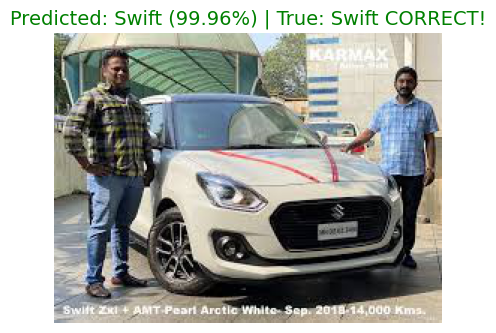

Class probabilities:
       Audi                :  0.0056%
       Hyundai Creta       :  0.0003%
       Mahindra Scorpio    :  0.0025%
       Rolls Royce         :  0.0048%
* True Swift               : 99.9599%
       Tata Safari         :  0.0014%
       Toyota Innova       :  0.0255%


In [40]:
# --------------------------------------------------------------------------- #
# Show ONE truly random test image (from any class)

assert len(test_items) > 0, "No test images found."
rand_path, rand_true = random.choice(test_items)
show_image_prediction(rand_path, true_label=rand_true)

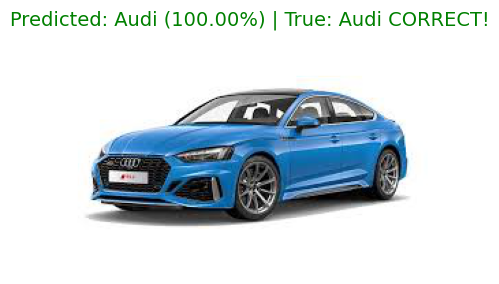

Class probabilities:
* True Audi                : 99.9966%
       Hyundai Creta       :  0.0000%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0034%
       Swift               :  0.0000%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0000%


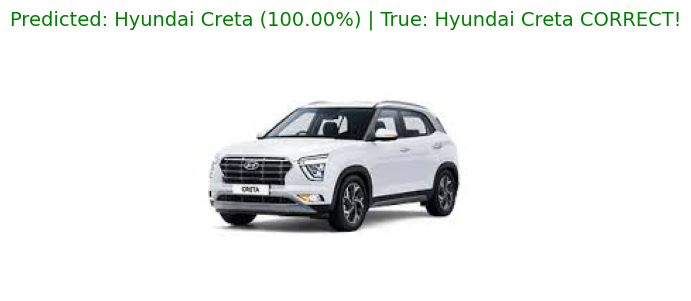

Class probabilities:
       Audi                :  0.0002%
* True Hyundai Creta       : 99.9996%
       Mahindra Scorpio    :  0.0001%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
       Tata Safari         :  0.0001%
       Toyota Innova       :  0.0001%


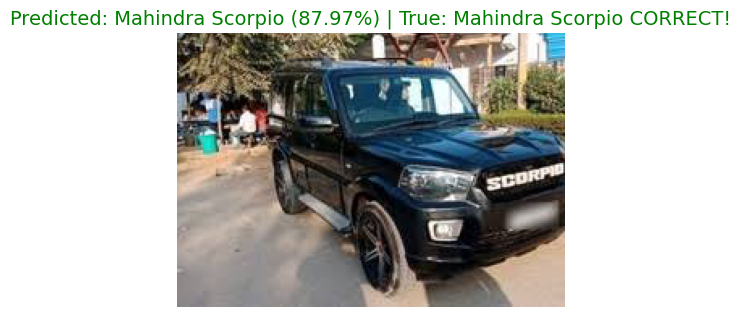

Class probabilities:
       Audi                :  1.3585%
       Hyundai Creta       :  5.0461%
* True Mahindra Scorpio    : 87.9724%
       Rolls Royce         :  2.2811%
       Swift               :  0.1679%
       Tata Safari         :  0.3624%
       Toyota Innova       :  2.8116%


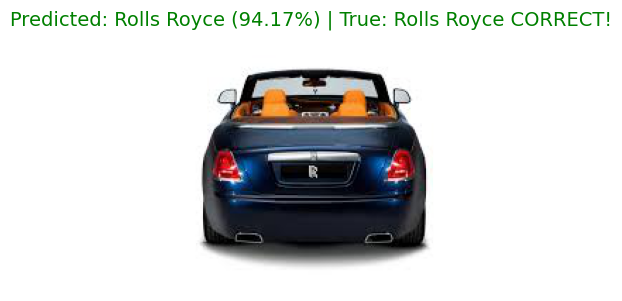

Class probabilities:
       Audi                :  0.1808%
       Hyundai Creta       :  0.5956%
       Mahindra Scorpio    :  2.0792%
* True Rolls Royce         : 94.1742%
       Swift               :  0.4331%
       Tata Safari         :  0.3265%
       Toyota Innova       :  2.2106%


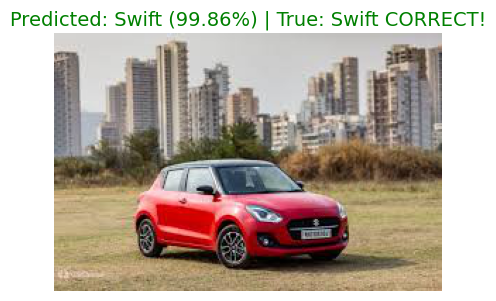

Class probabilities:
       Audi                :  0.0034%
       Hyundai Creta       :  0.1068%
       Mahindra Scorpio    :  0.0142%
       Rolls Royce         :  0.0131%
* True Swift               : 99.8574%
       Tata Safari         :  0.0033%
       Toyota Innova       :  0.0017%


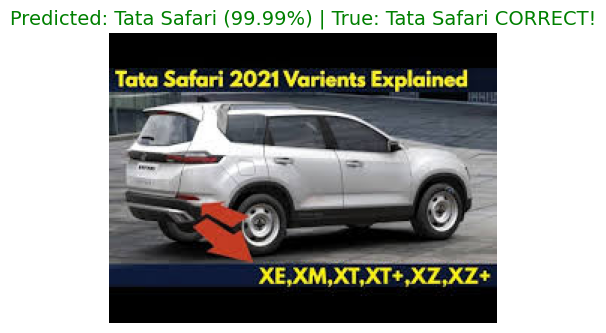

Class probabilities:
       Audi                :  0.0002%
       Hyundai Creta       :  0.0108%
       Mahindra Scorpio    :  0.0001%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
* True Tata Safari         : 99.9888%
       Toyota Innova       :  0.0001%


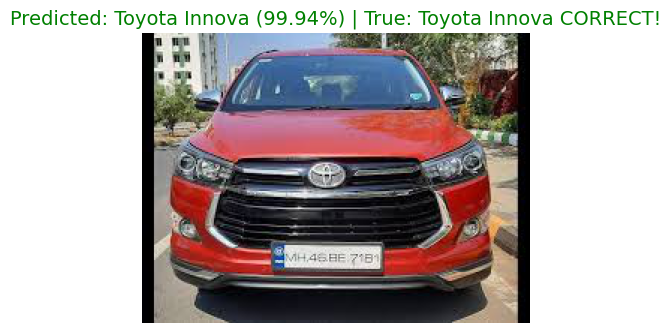

Class probabilities:
       Audi                :  0.0009%
       Hyundai Creta       :  0.0095%
       Mahindra Scorpio    :  0.0008%
       Rolls Royce         :  0.0005%
       Swift               :  0.0523%
       Tata Safari         :  0.0001%
* True Toyota Innova       : 99.9358%


In [41]:
# Show ONE random image PER CLASS (balanced peek)

for cls in class_names:
    candidates = test_by_class.get(cls, [])
    if not candidates:
        print(f"[skip] No images found for class: {cls}")
        continue
    img_path = random.choice(candidates)
    show_image_prediction(img_path, true_label=cls)

### NEXT --> BUILD CONFUSION MATRIX (text & plot), classification_report; ###

In [43]:
import torch

def evaluate_model_with_cm_params(model, test_loader, device):
    """
    Evaluate a PyTorch model on test data and return accuracy plus
    the predictions and true labels needed for a confusion matrix / classification report.

    Args:
        model:       PyTorch model to evaluate (already moved to device)
        test_loader: DataLoader for test data
        device:      torch.device set earlier in your notebook

    Returns:
        test_acc (float): Test accuracy in percent (0-100)
        all_preds (np.ndarray): Predicted class indices for the entire test set
        all_labels (np.ndarray): True class indices for the entire test set
    """
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # accumulate accuracy numerators/denominators
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

            # store for CM / report later
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    test_acc = (correct / total * 100) if total > 0 else 0.0
    print(f"Test Accuracy: {test_acc:.4f}%")

    return test_acc, all_preds, all_labels

In [44]:
test_acc, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 96.0640%


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


print(classification_report(all_labels, all_preds, digits=4))
confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

           0     0.9598    0.9598    0.9598       199
           1     0.9254    0.9254    0.9254        67
           2     0.9733    0.9733    0.9733        75
           3     0.9710    0.9054    0.9371        74
           4     0.9619    0.9902    0.9758       102
           5     0.9626    0.9717    0.9671       106
           6     0.9634    0.9684    0.9659       190

    accuracy                         0.9606       813
   macro avg     0.9596    0.9563    0.9578       813
weighted avg     0.9607    0.9606    0.9605       813



array([[191,   1,   1,   2,   2,   1,   1],
       [  1,  62,   0,   0,   0,   2,   2],
       [  0,   0,  73,   0,   1,   0,   1],
       [  5,   0,   1,  67,   0,   1,   0],
       [  0,   0,   0,   0, 101,   0,   1],
       [  0,   1,   0,   0,   0, 103,   2],
       [  2,   3,   0,   0,   1,   0, 184]])

<Figure size 1200x1200 with 0 Axes>

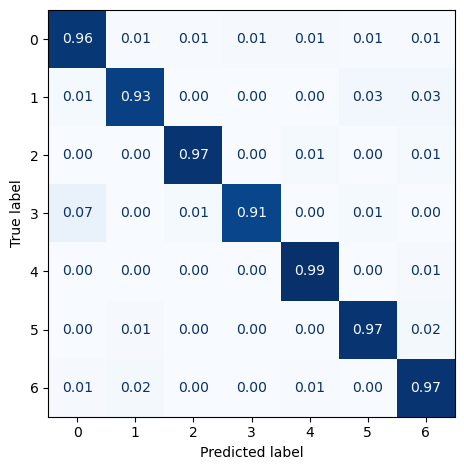

In [57]:
%matplotlib inline 
# ConfusionMatrixDisplay.from_predictions()

plt.figure(figsize=(12, 12)) 

disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize="true", cmap="Blues", colorbar=False
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.tight_layout()
plt.show();

In [58]:
from torchinfo import summary

In [62]:
# get a batch shape for summary
images, labels = next(iter(train_loader))

input_shape = images.shape

torch.Size([32, 3, 288, 288])

In [63]:
# Create a dummy input tensor with the same shape as your actual input
input_shape = images.shape
dummy_input = torch.randn(input_shape).to(device)

# Use the summary method to get a detailed summary of your model
summary(model, input_size=input_shape, )

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 7]                   --
├─Sequential: 1-1                                       [32, 1408, 9, 9]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 144, 144]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 144, 144]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]        --
│    └─Sequential: 2-2                                  [32, 16, 144, 144]        --
│    │    └─MBConv: 3-4                                 [32, 16, 144, 144]        (1,448)
│    │    └─MBConv: 3-5                                 [32, 16, 144, 144]        (612)
│    └─Sequential: 2-3                                  [32, 24, 72, 72]          --
│    │    └─MBConv: 3-6                        

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [69]:
from torchinfo import summary
import torch

# Convert the input_shape to a tuple
input_size = input_shape

# Print a summary using torchinfo
summary(model=model,
        input_size=input_size  # Use the dynamically generated input_size
        , col_names=["input_size"
                     # , "output_size" # can have input_size or output_size (not both) due to size constraints
                     # ^ (cont.) I also find adjusting nb to '100% width' often breaks other things;
                     , "num_params"
                     , "trainable"
                    ]
        , col_width=20
        , row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   --                   False
│    │    └─MBConv (0)                                       [32, 32, 144, 144]   (1,448)              False
│    │    └─MB

In [71]:
from IPython.display import display, HTML
display(HTML("<style>.output_result { max-width: 100% !important; }</style>"))

# Convert the input_shape to a tuple
input_size = input_shape

# Print a summary using torchinfo
summary(model=model,
        input_size=input_size  # Use the dynamically generated input_size
        , col_names=["input_size"
#                    , "output_size"
                     , "num_params"
                     , "trainable"
                    ]
        , col_width=20
        , row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   --                   False
│    │    └─MBConv (0)                                       [32, 32, 144, 144]   (1,448)              False
│    │    └─MB